# Multiplex Fabry-Perot interferometer

This notebook implements the model of a FP interferometer as described in the paper "Multiplex Fabry-Perot interferometer: I. Theory" by William B. Cook, Hilary E. Snell and Paul B. Hays, Applied optics 1995. Some of the figures in the paper are reproduced below.

The model considered for the FPI is the following.

$$I(x) = \int_0^\infty B(\sigma)d\sigma + 2 \int_0^\infty B(\sigma) \sum_{n=1}^\infty R^n cos(2 \pi n \sigma x) d\sigma $$


In [ ]:
# ! pip install matplotlib
# ! pip install ipywidgets

  Using cached ipywidgets-8.1.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.11-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.3-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.11-py3-none-any.whl (2.3 MB)


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

from ipywidgets import interact, fixed
import ipywidgets as widgets

from scipy.stats import norm


In [2]:
# define the value of some parameters
sigma0 = 2600  # [cm^-1] center wave number
R = 0.9 # plate reflectivity
# x = 0.0083 # OPD

# x = np.linspace(0, 2*np.pi)
x = np.arange(0, 0.02, 0.0001)

# sigma = np.arange(0, 0.02, 0.0001)
# print(x)

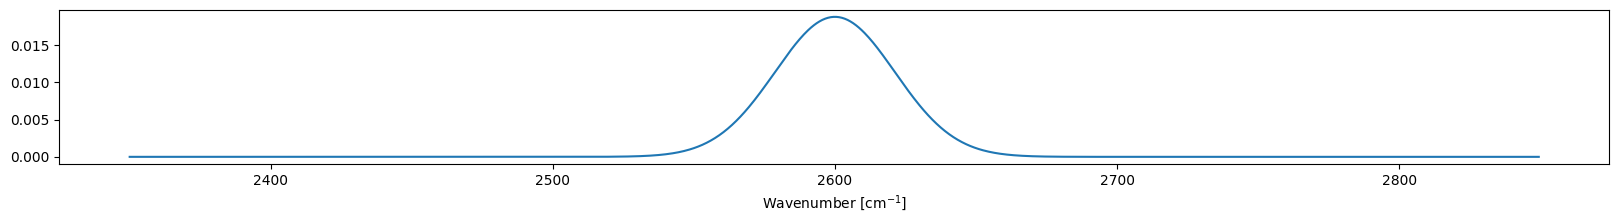

In [161]:
# Spectrum of a Gaussian source centered in sigma0
hwhm = 30 # [cm^-1]
fwhm = 2*hwhm
std = fwhm/(2*np.sqrt(2*np.log2(2)))


#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
gauss_src = norm(loc = sigma0, scale = std)

sigma_step = 0.5 # [cm^-1]
sigma_nsamples = 500
sigma = np.arange(sigma0-sigma_nsamples*sigma_step, sigma0+sigma_nsamples*sigma_step, sigma_step)

B = gauss_src.pdf(sigma)

#plot the pdfs of these normal distributions 
plt.figure(figsize=[20,2])  
plt.plot(sigma, B)
plt.xlabel("Wavenumber [cm$^{-1}$]")
plt.show()

In [122]:
# Functions that will be used in the following
def fp_tfun(sigma, x, R, N, B=np.ones(sigma.shape), phase=0):
    '''Transfer function of a Fabry-Perot intereferometer'''
    # sigma: wavenumber samples
    # x: OPD
    # R: reflectivity of the plates
    # N: number of waves in the model
    # phase: phase term

    I = np.zeros(sigma.shape)
    
    for n in range(N):
        I = I + R**(n+1) * B * np.cos(2*np.pi*(n+1)*x*(sigma-phase))

    return I


def fpi (B, sigma, x, R, N):
    """Compute a Fabry-Perot interferogram"""

    I = np.zeros(x.shape)

    # loop on the reflected wave 
    for i, xi in enumerate(x):
        for n in range(N):
            I[i] = I[i] + R**(n+1) * B @ np.cos(2*np.pi*(n+1)*sigma*xi).T

    return I


Plot the transfer function of the FPI wrt to different values of thickness, reflectivity and number of waves. 
The transfer function in the wavenumber domain is superimposed to the input source.

In [162]:

# sigma = np.arange(0, 0.02, 0.0001)
sigma_step = 0.5 # [cm^-1]
sigma_nsamples = 500
sigma = np.arange(sigma0-sigma_nsamples*sigma_step, sigma0+sigma_nsamples*sigma_step, sigma_step)

gauss_src = norm(loc = sigma0, scale = std)
B = gauss_src.pdf(sigma)

def plot_fpi_tfun(opd, R=0.9, N=10, sigma=sigma, B=None):
    
    y = fp_tfun(sigma=sigma, x=opd, R=R, N=N, B=np.ones(sigma.shape), phase=sigma0)

    # Normalize the function
    if opd != 0:
        y = y-y.min()
        y = y/y.max()
    
    plt.figure(figsize=[20,5])
    plt.plot(sigma, y)
    if B.all():
        plt.plot(sigma, B/B.max(), 'r')
    plt.title(f'FP transfer function - OPD={opd:0.4f} [cm$^{-1}$], R={R:0.2f}, N={N}')
    plt.ylim(-0.5,+1.5)
    plt.xlabel('Wavenumber [cm$^{-1}$]')
    plt.show()

# plot_fpi_tfun(0.0083)    

interact(plot_fpi_tfun, 
         opd = widgets.FloatSlider(value=0.0083, min=0, max=0.04, step=0.0001), 
         R = widgets.FloatSlider(value=0.9, min=0, max=0.99, step=0.01), 
         N = widgets.IntSlider(value=100, min=2, max=100, step=1),
         sigma=fixed(sigma),
         B=fixed(B)
         )
plt.show()


interactive(children=(FloatSlider(value=0.0083, description='opd', max=0.04, step=0.0001), FloatSlider(value=0…

Plot the interferogram of the input source.
Possible to change the central wavenumber of the input source.

In [118]:
# x = 0.0083 # OPD
# x = np.arange(0, 0.02, 0.00001)
# I = fpi(B, sigma, x, R=0.3, N=10)

# plt.figure(figsize=[20,5])
# plt.plot(x, I)

def plot_fpi(R=0.9, N=10, sigma0=2600):

    fwhm = 30 # [cm^-1]
    std = fwhm/(2*np.sqrt(2*np.log2(2)))


    #initialize a normal distribution with frozen in mean=-1, std. dev.= 1
    gauss_src = norm(loc = sigma0, scale = std)

    sigma_step = 0.5 # [cm^-1]
    sigma_nsamples = 500
    sigma = np.arange(sigma0-sigma_nsamples*sigma_step, sigma0+sigma_nsamples*sigma_step, sigma_step)

    B = gauss_src.pdf(sigma)
 
    opds = np.arange(0, 0.02, 0.00001)
    
    y = fpi(B=B, sigma=sigma, x=opds, R=R, N=N)

    yf = fft.dct(y)
    
    plt.figure(figsize=[20,3])
    plt.plot(opds, y)
    plt.title(f'FP interferogram - R={R:0.2f}, N={N}')
    # plt.ylim(-2,+25)
    plt.xlabel('OPD [cm?]')
    plt.show()

    plt.figure(figsize=[20,3])
    plt.plot(yf)
    plt.title(f'Spectrum of the FP interferogram - R={R:0.2f}, N={N}')
    # plt.ylim(-2,+25)
    plt.xlabel('frequency')
    plt.show()

# plot_fpi_tfun(0.0083)    

interact(plot_fpi, 
         sigma0 = widgets.FloatSlider(value=2600, min=1000, max=4000, step=10), 
         R = widgets.FloatSlider(value=0.9, min=0, max=0.99, step=0.01), 
         N = widgets.IntSlider(value=90, min=2, max=100, step=1))

interactive(children=(FloatSlider(value=0.9, description='R', max=0.99, step=0.01), IntSlider(value=90, descri…

<function __main__.plot_fpi(R=0.9, N=10, sigma0=2600)>